**This section imports all the libraries and dependencies required**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pickle
import string
import re
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prateek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Importing labelled tweets from 'labelled_data.csv' and storing it in a pandas dataframe**

In [2]:
df = pd.read_csv('labelled_data.csv',encoding = 'latin', index_col=False, header = None)
df.columns = ['Sentiment', 'ID', 'Date', 'Query', 'Uid', 'Tweet']
df.drop(['ID', 'Date', 'Query', 'Uid'], axis=1, inplace = True)
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
df['Sentiment'].value_counts()

0    800000
4    800000
Name: Sentiment, dtype: int64

**Function for cleaning text using regular expression**

In [4]:
def cleanTwt(twt):
    if type(twt) == np.float64:
        return ""
    twt = twt.lower()
    twt = re.sub("'", "", twt) # to avoid removing contractions in english
    twt = re.sub("@[A-Za-z0-9_]+","", twt)
    twt = re.sub("#[A-Za-z0-9_]+","", twt)
    twt = re.sub(r'http\S+', '', twt)
    twt = re.sub('[()!?]', ' ', twt)
    twt = re.sub('\[.*?\]',' ', twt)
    twt = re.sub("[^a-z0-9]"," ", twt)
    return twt

**Function for tokenizing text in tweets**

In [5]:
stop_words = set(stopwords.words('english'))
def tokenization(text):
    ps = nltk.PorterStemmer()
    text = re.split('\W+', text)
    text = [word for word in text if word not in stop_words]
    text = [ps.stem(word) for word in text]
    text = list(filter(None, text))
    text = " ".join(word for word in text)
    return text

In [6]:
df['ProcessedTweets'] = df['Tweet'].apply(cleanTwt).apply(tokenization)
df.head()

,Sentiment,Tweet,ProcessedTweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save 50 rest go bound
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",behav im mad cant see


In [7]:
X = df['ProcessedTweets'].copy()
y = df['Sentiment'].copy()
y[y==0] = 0
y[y==4] = 1

**Word cloud of tweets with positive sentiments**

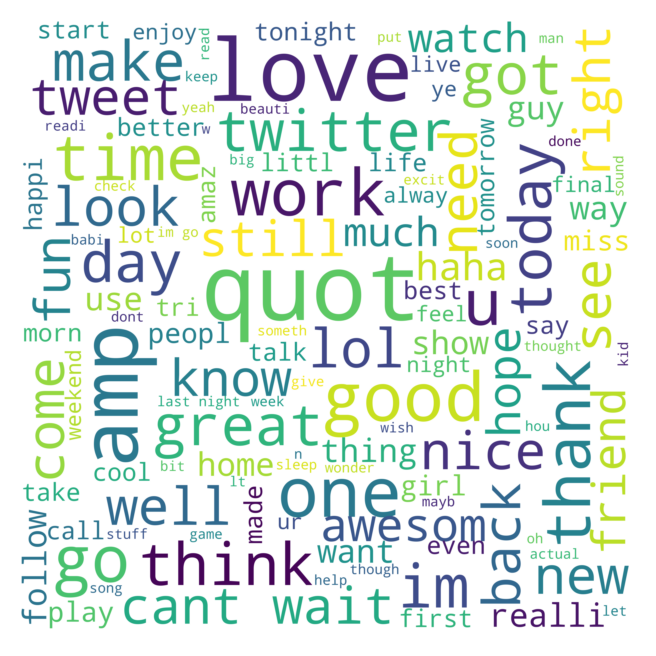

In [8]:
word_cloud_text = ''.join(X.values[y.values==1])
wordcloud = WordCloud(
    max_font_size=60,
    max_words=120,
    background_color="white",
    scale=10,
    width=400,
    height=400
).generate(word_cloud_text)

plt.figure(dpi=200, figsize=(4,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Word cloud of tweets with negative sentiments**

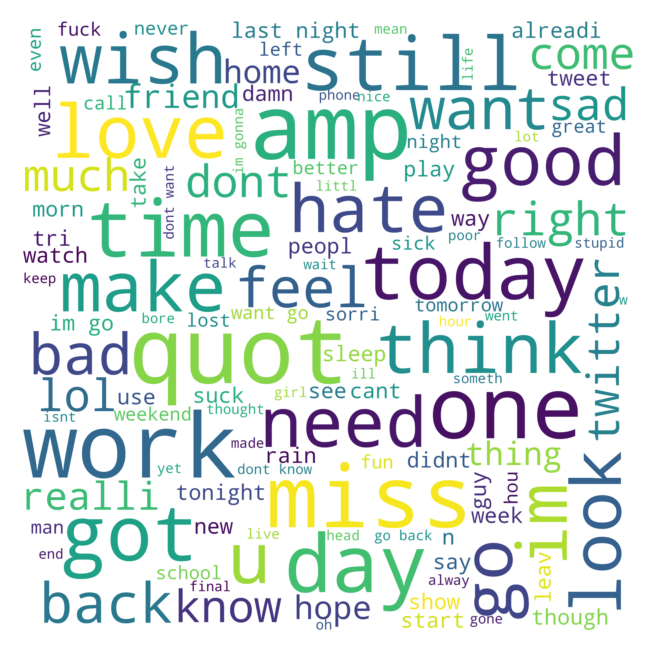

In [9]:
word_cloud_text = ''.join(X.values[y.values==0])
wordcloud = WordCloud(
    max_font_size=60,
    max_words=120,
    background_color="white",
    scale=10,
    width=400,
    height=400
).generate(word_cloud_text)

plt.figure(dpi=200, figsize=(4,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Splitting training and testing data**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

cv = CountVectorizer()
train_data = cv.fit_transform(X_train)
test_data = cv.transform(X_test)

In [11]:
train_data.shape[1]

184078

**Hyperparameter tuning for XGBoost classifier**

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [15, 20],
    'learning_rate': [0.1, 0.25, 0.5]
}

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = GridSearchCV(model, param_grid=param_grid, cv=4, verbose=3, scoring='accuracy')
grid_search.fit(train_data, y_train.values)

print('Best Parameters:', grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4] END learning_rate=0.1, max_depth=15, n_estimators=500;, score=0.774 total time= 1.1min
[CV 2/4] END learning_rate=0.1, max_depth=15, n_estimators=500;, score=0.774 total time= 1.1min
[CV 3/4] END learning_rate=0.1, max_depth=15, n_estimators=500;, score=0.773 total time= 1.1min
[CV 4/4] END learning_rate=0.1, max_depth=15, n_estimators=500;, score=0.774 total time= 1.2min
[CV 1/4] END learning_rate=0.1, max_depth=15, n_estimators=1000;, score=0.781 total time= 2.3min
[CV 2/4] END learning_rate=0.1, max_depth=15, n_estimators=1000;, score=0.781 total time= 2.4min
[CV 3/4] END learning_rate=0.1, max_depth=15, n_estimators=1000;, score=0.781 total time= 2.4min
[CV 4/4] END learning_rate=0.1, max_depth=15, n_estimators=1000;, score=0.782 total time= 2.4min
[CV 1/4] END learning_rate=0.1, max_depth=20, n_estimators=500;, score=0.777 total time= 1.6min
[CV 2/4] END learning_rate=0.1, max_depth=20, n_estimators=500;, score=

**Training XGBoost classifier with best hyperparameters obtained from GridSearchCV**

In [13]:
xgb_classifier = xgb.XGBClassifier(max_depth = grid_search.best_params_['max_depth'],
                                   learning_rate = grid_search.best_params_['learning_rate'],
                                   n_estimators = grid_search.best_params_['n_estimators'],
                                   objective = 'binary:logistic',
                                   eval_metric = 'logloss')

xgb_classifier.fit(train_data, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [14]:
y_pred = xgb_classifier.predict(test_data)

accuracy = accuracy_score(y_test.values, y_pred)
print('XGBoost classifier accuracy:', accuracy)

XGBoost classifier accuracy: 0.7898458333333334


**Save Model as Pickle**

In [15]:
file_name = "XGBoost_Sentiment.pkl"
pickle.dump(xgb_classifier, open(file_name, "wb"))

**Creating neural network using sequential model in TensorFlow with three dense layers**

In [16]:
model = Sequential([
    Dense(64, input_dim=train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                11781056  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,783,169
Trainable params: 11,783,169
Non-trainable params: 0
_________________________________________________________________


**Generator to create small batches of sparse data for model training**

In [19]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    y_data = y_data.values
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0

In [20]:
batch_size = 500
history = model.fit(nn_batch_generator(train_data, y_train, batch_size), 
                    steps_per_epoch = int(np.ceil(train_data.shape[0]/batch_size)),
                    epochs=10)

Epoch 1/10
2240/2240 [==============================] - 850s 379ms/step - loss: 0.4782 - accuracy: 0.7749
Epoch 2/10
2240/2240 [==============================] - 847s 378ms/step - loss: 0.4204 - accuracy: 0.8082
Epoch 3/10
2240/2240 [==============================] - 850s 379ms/step - loss: 0.3762 - accuracy: 0.8324
Epoch 4/10
2240/2240 [==============================] - 847s 378ms/step - loss: 0.3390 - accuracy: 0.8509
Epoch 5/10
2240/2240 [==============================] - 843s 376ms/step - loss: 0.3111 - accuracy: 0.8639
Epoch 6/10
2240/2240 [==============================] - 849s 379ms/step - loss: 0.2902 - accuracy: 0.8731
Epoch 7/10
2240/2240 [==============================] - 854s 381ms/step - loss: 0.2748 - accuracy: 0.8802
Epoch 8/10
2240/2240 [==============================] - 861s 385ms/step - loss: 0.2624 - accuracy: 0.8858
Epoch 9/10
2240/2240 [==============================] - 856s 382ms/step - loss: 0.2525 - accuracy: 0.8900
Epoch 10/10
2240/2240 [=======================

In [21]:
loss_nn, accuracy_nn = model.evaluate(test_data, y_test.values)
print('Neural network model accuracy:', accuracy_nn)


15000/15000 [==============================] - 9s 566us/step - loss: 0.6790 - accuracy: 0.7733
Neural network model accuracy: 0.7732895612716675


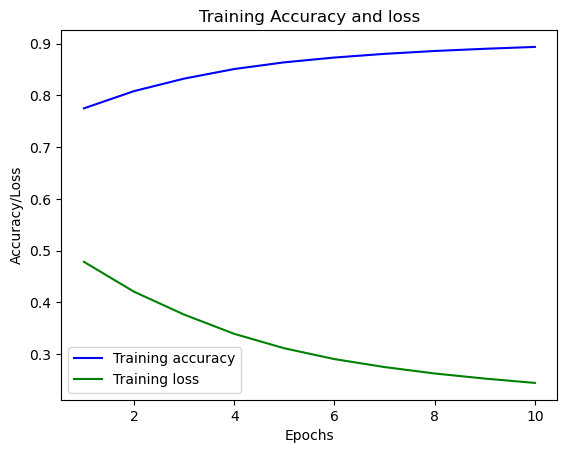

In [22]:
loss_train = history.history['loss']
acc_train = history.history['accuracy']
epochs = range(1,11)
plt.plot(epochs, acc_train, 'b', label='Training accuracy')
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training Accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

In [23]:
model.save('NN_Sentiment')

INFO:tensorflow:Assets written to: NN_Sentiment\assets


INFO:tensorflow:Assets written to: NN_Sentiment\assets


**Loading unlabelled tweets to predict sentiment using trained models**

In [24]:
test_df = pd.read_csv('unlabelled_tweets.csv', index_col=False)
test_df.drop(['Unnamed: 0', 'Verified', 'Date', 'ID', 'Location'], axis=1, inplace = True)
test_df.head()

,Tweets
0,"Because some people love Bitcoin, but hate cry..."
1,Will those who buy $BTC right now be considere...
2,This was a fun and quite informative podcast. ...
3,@PeterSchiff @saylor @TuckerCarlson In fairnes...
4,"@joseclibas, Earn Bitcoin while protecting you..."


**Cleaning and tokenizing text in the tweets**

In [25]:
test_df['ProcessedTweets'] = test_df['Tweets'].apply(cleanTwt).apply(tokenization)
test_df.head()

,Tweets,ProcessedTweets
0,"Because some people love Bitcoin, but hate cry...",peopl love bitcoin hate crypto gener even link...
1,Will those who buy $BTC right now be considere...,buy btc right consid hero
2,This was a fun and quite informative podcast. ...,fun quit inform podcast check tesla bitcoin tsla
3,@PeterSchiff @saylor @TuckerCarlson In fairnes...,fair say mistak sinc bitcoin dollar proven wro...
4,"@joseclibas, Earn Bitcoin while protecting you...",earn bitcoin protect text voic scam gabriel cr...


**Word cloud of unlabelled tweets**

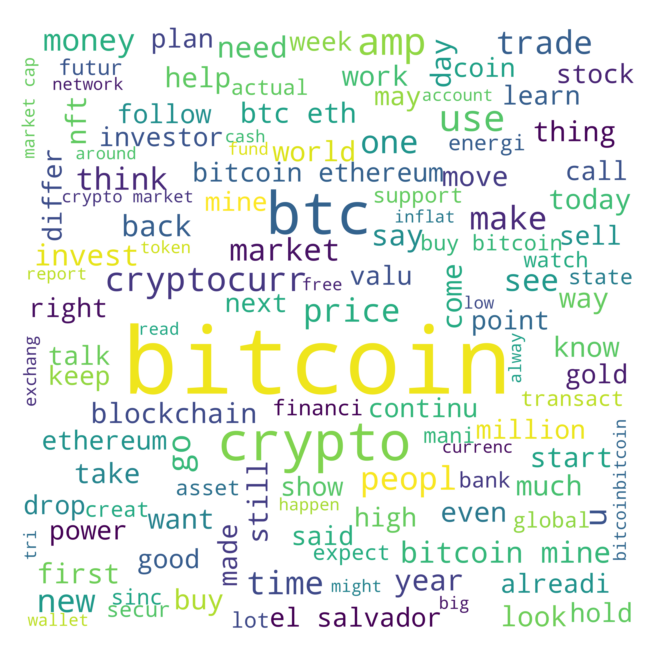

In [26]:
word_cloud_text = ''.join(test_df['ProcessedTweets'].values)
wordcloud = WordCloud(
    max_font_size=60,
    max_words=120,
    background_color="white",
    scale=10,
    width=400,
    height=400
).generate(word_cloud_text)

plt.figure(dpi=200, figsize=(4,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
cv_data = cv.transform(test_df['ProcessedTweets'])

**Determining polarity of the text in the tweet using TextBlob**

In [28]:
import textblob as tb

def getPolarity(text):
    return tb.TextBlob(text).sentiment.polarity

y = test_df['ProcessedTweets'].apply(getPolarity)
y[y>0] = 1
y[y<0] = 0
test_df['TextBlob'] = y
test_df.head()

,Tweets,ProcessedTweets,TextBlob
0,"Because some people love Bitcoin, but hate cry...",peopl love bitcoin hate crypto gener even link...,0.0
1,Will those who buy $BTC right now be considere...,buy btc right consid hero,1.0
2,This was a fun and quite informative podcast. ...,fun quit inform podcast check tesla bitcoin tsla,1.0
3,@PeterSchiff @saylor @TuckerCarlson In fairnes...,fair say mistak sinc bitcoin dollar proven wro...,1.0
4,"@joseclibas, Earn Bitcoin while protecting you...",earn bitcoin protect text voic scam gabriel cr...,0.0


**Sentiment Prediction using XGBoost Classifier**

In [29]:
data_pred = xgb_classifier.predict(cv_data)
test_df['XgBoost'] = data_pred
test_df.head()

,Tweets,ProcessedTweets,TextBlob,XgBoost
0,"Because some people love Bitcoin, but hate cry...",peopl love bitcoin hate crypto gener even link...,0.0,0
1,Will those who buy $BTC right now be considere...,buy btc right consid hero,1.0,1
2,This was a fun and quite informative podcast. ...,fun quit inform podcast check tesla bitcoin tsla,1.0,1
3,@PeterSchiff @saylor @TuckerCarlson In fairnes...,fair say mistak sinc bitcoin dollar proven wro...,1.0,0
4,"@joseclibas, Earn Bitcoin while protecting you...",earn bitcoin protect text voic scam gabriel cr...,0.0,0


**Sentiment Prediction using Neural Network**

In [30]:
y_nn = model.predict(cv_data)
y_nn[y_nn>=0.5] = 1
y_nn[y_nn<0.5] = 0
test_df['NN'] = y_nn
test_df.head()

227/227 [==============================] - 0s 604us/step


,Tweets,ProcessedTweets,TextBlob,XgBoost,NN
0,"Because some people love Bitcoin, but hate cry...",peopl love bitcoin hate crypto gener even link...,0.0,0,0.0
1,Will those who buy $BTC right now be considere...,buy btc right consid hero,1.0,1,0.0
2,This was a fun and quite informative podcast. ...,fun quit inform podcast check tesla bitcoin tsla,1.0,1,1.0
3,@PeterSchiff @saylor @TuckerCarlson In fairnes...,fair say mistak sinc bitcoin dollar proven wro...,1.0,0,0.0
4,"@joseclibas, Earn Bitcoin while protecting you...",earn bitcoin protect text voic scam gabriel cr...,0.0,0,1.0
